In [269]:
import osOps  # see github.com/romstroller/FileTools
import dUtils as utls

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import nltk
import os

# Gender in a million headlines
**[romstroller.au](http://www.romstroller.au/) | 
[github.com/romstroller](https://github.com/romstroller/)**

![](http://www.romstroller.au/wp-content/uploads/2022/10/factbookGraphic.jpg)

***
### OBJECTIVE

This report examines the comparative prominence of different genders in the 
main subject matter of news communications - specifically, how the balance of 
coverage between male and female individuals or groups, by frequency of words 
in a headline, has changed through time. Analysis is limited to headlines from 
the Australian national broadcaster (the ABC). The aim is to establish the 
scope and support for editorial policy changes which enable a distribution of 
gender-reference in media that best represents the gender-distribution of 
the population itself.

**STAKEHOLDERS:** Media institution editorial policy-makers

**OUTCOME:** Key datapoint: From the earliest headline in the dataset (February 
2003), the balance of headlines containing gendered pronouns shifted from 0.43 
(female-to-male) before March 2021 to 0.81 until end-range (December the same year).
This is an encouraging improvement, but falls far short of the natural 
population ratio of approximately 1-to-1.

### DATA acquisition, cleaning and feature engineering

In [270]:
dfOR = osOps.OsKit().getKaggleSet( 'therohk', 'million-headlines' )

utls.write( [
    (f"n. headlines", f"{dfOR.shape[ 0 ]}"),
    (f"mean mo/h'lines",
    f"{dfOR.groupby( 'publish_date' ).count().mean()[ 0 ]:.2f}"),
    (f"mean h'line/words",
    f"{dfOR[ 'headline_text' ].str.split().str.len().mean():.2f}"),
    (f"oldest h'line",
    f"{(dfDat := sorted( dfOR.publish_date.to_list() ))[ 0 ]}"),
    (f"newest h'line", f"{dfDat[ -1 ]}"), ], bullets=True )

- [221103_144407548820] Got 'million-headlines.zip'
                        Dated: 2022_08_30_13_12_02_078157


- n. headlines         1244184
 - mean mo/h'lines      180.79
 - mean h'line/words    6.56
 - oldest h'line        20030219
 - newest h'line        20211231

The dataset comprises around 1.25 million headlines dated from February 2003 to 
December 2021, averaging 180 per month of around 6.5 words each.

In order to analyse gender-reference frequency, or the number of times 
particular gender pronouns are used in a given day, each headline is to be 
split on each word, retaining the date indexation for each word, and keeping a 
reference to the originating headline index.

In [271]:
df = dfOR.assign( headline_text=dfOR[ 'headline_text' ].str.split( ' ' )
    ).explode( 'headline_text' ).reset_index()

df.columns = [ "hNum", "date", "word" ]

df

,hNum,date,word
0,0,20030219,aba
1,0,20030219,decides
2,0,20030219,against
3,0,20030219,community
4,0,20030219,broadcasting
...,...,...,...
8158762,1244183,20211231,here
8158763,1244183,20211231,are
8158764,1244183,20211231,the
8158765,1244183,20211231,new


#### Dimensionality and noise reduction
The word frequency data contains a lot of noise from words which perform only a 
syntactical function - "stopwords", usually nonsubstantive prepositions and 
conjunctions like "a", "and", "the", which appear among maxima in frequency 
counts because they are required for common construction. For this analysis, 
where a stopword is not itself a gender pronoun, it can be excluded from the 
dataset as a processing convenience.

#### Gender keywords
Gendered individuals as objects of communication can be estimated to occur, in 
a set where non-gendered stopwords are omitted: for males, equally with "man" 
and "men", and for females, likewise with "woman" and "women".

#### Get count omitting stopwords

In [272]:
def returnCounts( _df ):
    _dfFilt = _df[ ~_df[ 'word' ].isin( stopwordsV1 ) ]
    _counted = Counter( _dfFilt[ 'word' ].tolist() )
    return _counted.most_common()


# get and omit non-gen stopwords, run counter
nltk.download( 'stopwords', download_dir=os.getcwd(), quiet=True )
with open( "corpora\stopwords\english", 'r' ) as f:
    stopwords = [ line.strip() for line in f ]

wo = [ "woman", "women", "female", "females", "she", "her", "hers", "herself" ]
ma = [ "man", "men", "male", "males", "he", "him", "his", "himself" ]
# Matching is seg of headline delimited by whitespace matches exact pronoun; 
#   EXTEND: Regex to include eg. plurals and punc-delimited to capture fuller
#   syntactical variations but not false-match ( eg. man in "human" )

stopwordsV1 = [ x for x in stopwords if x not in wo + ma ]
dfNS = df[ ~df[ 'word' ].isin( stopwordsV1 ) ]

print( f"Top 15 most common:" )
for c in (mostCom := returnCounts( df[ ~df[ 'word' ].isin( stopwordsV1 ) ] ))[ :15 ]:
    print( "    - ", c )

Top 15 most common:
    -  ('police', 39813)
    -  ('new', 33729)
    -  ('man', 30627)
    -  ('says', 23731)
    -  ('us', 20370)
    -  ('court', 18180)
    -  ('govt', 17091)
    -  ('australia', 17071)
    -  ('council', 16955)
    -  ('nsw', 16516)
    -  ('fire', 15512)
    -  ('interview', 15426)
    -  ('australian', 13632)
    -  ('wa', 13464)
    -  ('sydney', 13065)


***

###  ANALYSIS, Interpretation and Visualisation

#### Initial observations

A key, distinct insight for our objective is already available at this point:
*man* is the third-most common word altogether, gendered or otherwise, in 
this cleaned dataset, while none of our female pronouns are even in the 
top 25. How are the female pronouns ranked?

In [273]:
utls.write( [
    (f"rank {i + 1} (count: {x[ 1 ]} )", f"{x[ 0 ]}")
    for i, x in enumerate( mostCom ) if x[ 0 ] in wo + ma ], bullets=True )

- rank 3 (count: 30627 )      man
 - rank 37 (count: 9463 )      woman
 - rank 246 (count: 3867 )     women
 - rank 264 (count: 3707 )     his
 - rank 322 (count: 3160 )     men
 - rank 595 (count: 2099 )     he
 - rank 858 (count: 1537 )     her
 - rank 1186 (count: 1158 )    female
 - rank 2385 (count: 551 )     she
 - rank 2452 (count: 534 )     himself
 - rank 2567 (count: 505 )     him
 - rank 3699 (count: 317 )     male
 - rank 7942 (count: 103 )     herself
 - rank 17280 (count: 27 )     males
 - rank 17694 (count: 26 )     females
 - rank 111868 (count: 1 )     hers

"Woman" doesn't get in the ranking until 37th, over three times less-frequently 
than "man". Interestingly, "women" then appears at 246th, slightly above "men" 
at 322nd (with a count-difference of ~700, compared with "man" appearing ~20,000 
more times than "woman"). 

In the simplistic limitations of our analysis, if a group of gendered people is 
of concern, it is slightly more likely to be of women, while if a gendered 
individual is of concern, it is more likely to be a man.

The disparity between possessive pronouns is significant - "hers" is used in 
only one headline in the entire collection, while "his" appears 3707 times.

To clearly present the shifting balance of gendered pronouns through time, 
the count of male versus female pronouns from the beginning to end date of the 
dataset is collected by month and plotted in overlay.


In [274]:
def DFheadCount( _df, filt = None ):
    _df = _df.copy() if not filt else _df[ _df[ "word" ].isin( filt ) ].copy()
    _df[ "MO" ] = _df[ "date" ].floordiv( 100 )
    _df = (_df.drop( [ "word", "date" ], axis=1 )
           .groupby( 'MO' )[ 'hNum' ].nunique().reset_index())
    _df.columns = [ co for co in _df.columns[ :-1 ] ] + [ 'count' ]
    return _df


dfAll, dfW, dfM = [ DFheadCount( dfNS, fil ) for fil in [ None, wo, ma ] ]
dfMO = dfAll.merge( dfW, on='MO' ).merge( dfM, on='MO' )
dfMO.columns = [ "mo", "Ntot", "Nwom", "Nman" ]

dfMO

,mo,Ntot,Nwom,Nman
0,200302,2180,19,80
1,200303,6410,54,180
2,200304,6101,44,163
3,200305,6399,57,191
4,200306,6346,55,184
...,...,...,...,...
222,202108,1070,16,24
223,202109,1051,11,16
224,202110,988,20,26
225,202111,968,15,40


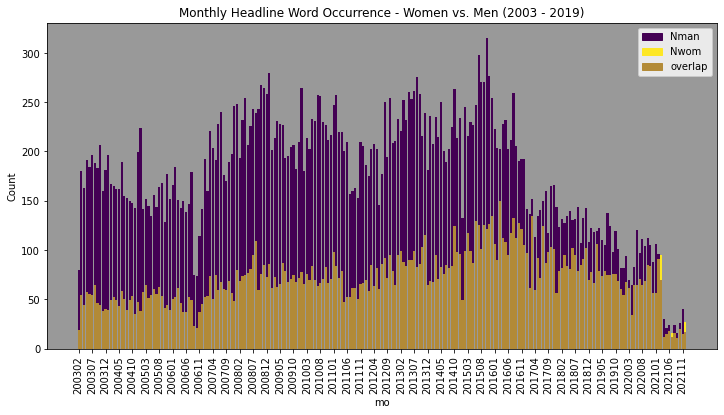

In [275]:
def plotOverlapping( _df, _xFt, _y1ft, _y2ft, yLab, figsiz, title = "" ):
    plt.figure( figsize=figsiz, facecolor="white", )
    
    x = _df[ _xFt ]
    xpos = [ i for i, _ in enumerate( x ) ]
    
    cols = { _y1ft: '#440154', _y2ft: '#fde725', 'overlap': "#b38b38" }
    
    plt.bar( xpos, _df[ _y2ft ], color=cols[ _y2ft ], )
    plt.bar( xpos, _df[ _y1ft ], color=cols[ _y1ft ], )
    plt.bar( xpos, _df[ _y2ft ], color=cols[ _y2ft ], alpha=0.6 )
    ax1 = plt.gca()
    ax1.set_facecolor( '#999999' )
    
    plt.xlabel( _xFt )
    plt.ylabel( yLab )
    plt.title( title )
    plt.xticks( xpos, x )
    plt.xticks( rotation=90 )
    ax1.locator_params( nbins=50, axis='x' )
    
    labs = list( cols.keys() )
    plt.legend( [ plt.Rectangle( (0, 0), 1, 1, color=cols[ lb ] )
        for lb in labs ], labs )
    
    plt.savefig(
        f'ghp_full{osOps.OsKit().dtStamp()}.png', bbox_inches='tight' )
    plt.show()


plotOverlapping( dfMO, 'mo', 'Nman', 'Nwom', "Count", (12, 6),
    title="Monthly Headline Word Occurrence - Women vs. Men (2003 - 2019)" )

In [276]:
firstParity = dfMO.loc[ dfMO[ 'Nwom' ] >= dfMO[ 'Nman' ], 'mo' ].iloc[ 0 ]

# Focus on segment where womCount equals or exceeds menCount
dfParity = dfMO[ dfMO[ 'mo' ] > firstParity - 3 ]

# average wom % men pre and post 201611, and all-time
dfMO[ "womPercMen" ] = dfMO.Nwom / dfMO.Nman
wpmAll = dfMO.womPercMen.mean()
dfPre201611 = dfMO[ dfMO[ 'mo' ] < 201611 ].copy()
dfPre201611[ "womPercMen" ] = dfPre201611.Nwom / dfPre201611.Nman
wpmPre201611 = dfPre201611.womPercMen.mean()
dfPos201611 = dfMO[ dfMO[ 'mo' ] >= 201611 ].copy()
dfPos201611[ "womPercMen" ] = dfPos201611.Nwom / dfPos201611.Nman
wpmPos201611 = dfPos201611.womPercMen.mean()

utls.write( [
    ("First Parity", firstParity),
    ("nWom % nMal", f"{wpmAll:.2f}"),
    ("W%M pre-1611", f"{wpmPre201611:.2f}"),
    ("W%M pos-1611", f"{wpmPos201611:.2f}"), ],
    bullets=True )

- First Parity    202103
 - nWom % nMal     0.45
 - W%M pre-1611    0.35
 - W%M pos-1611    0.70

- Male pronouns used far more often than female (female average frequency is 
0.45 that of male)
- Mostly (until end 2017), female pronouns are used on average 0.35 the 
frequency of male pronouns
- Female pronoun counts then rise rapidly to average 0.70 the male amount
- This convergence is ostensibly the result of male pronouns being 
used less frequently, rather than female pronouns being used more frequently
- Absolute parity is nearly reached in March 2017, possibly due to 
International Women's Day on the 8th.
- Parity is reached (exceeded) in March 2021 and several times afterward

Taking a closer look at the segment where parity is reached and exceeded - 
exceeded at first quite dramatically, at over twice the male frequency:

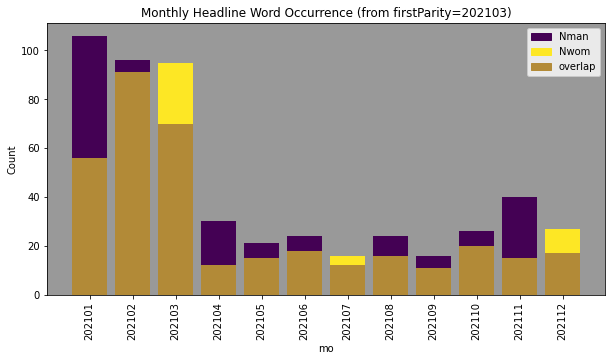

In [277]:
plotOverlapping( dfParity, 'mo', 'Nman', 'Nwom', "Count", (10, 5),
    title=f"Monthly Headline Word Occurrence (from {firstParity=})" )

In [278]:
# Checking difference in most-common distribution on PARITY date
#   between total and female-pronoun-containing

print( f"202103: Top 15 most common:" )
for c in returnCounts( df[ df[ 'date' ].astype( str ).str.startswith(
    '202103', na=False ) ] )[ :15 ]: print( "    - ", c )

# filter orig df by headlines containing female pronouns
dfOR_wom = dfOR[ dfOR[ 'headline_text' ].str.contains( '|'.join( wo ) ) ]

# # explode by headline word
df_WOM = dfOR_wom.assign( headline_text=dfOR_wom[ 'headline_text' ].str.split(
    ' ' ) ).explode( 'headline_text' ).reset_index()

df_WOM.columns = [ "hNum", "date", "word" ]

print( f"202103, filtered for female pronoun-containing: Top 15 most common:" )
for c in returnCounts( df_WOM[ df_WOM[ 'date' ].astype( str ).str.startswith(
    '202103', na=False ) ] )[ :15 ]: print( "    - ", c )

202103: Top 15 most common:
    -  ('covid', 166)
    -  ('vaccine', 95)
    -  ('nsw', 85)
    -  ('australia', 85)
    -  ('new', 84)
    -  ('19', 84)
    -  ('wa', 77)
    -  ('police', 67)
    -  ('says', 67)
    -  ('queensland', 67)
    -  ('coronavirus', 62)
    -  ('women', 62)
    -  ('australian', 53)
    -  ('sydney', 51)
    -  ('government', 49)
202103, filtered for female pronoun-containing: Top 15 most common:
    -  ('women', 62)
    -  ('womens', 18)
    -  ('woman', 16)
    -  ('weather', 16)
    -  ('says', 14)
    -  ('march', 14)
    -  ('nsw', 13)
    -  ('4', 10)
    -  ('female', 9)
    -  ('justice', 9)
    -  ('parliament', 9)
    -  ('her', 8)
    -  ('mother', 8)
    -  ('canberra', 8)
    -  ('wild', 7)


In the month (March 2021) that male pronoun-containing headlines are first 
outnumbered by female pronoun-containing headlines, a series of high-profile 
media events are occurring in relation to [various allegations of sex crimes in 
and around the membership of the Australian National Parliament](
https://en.wikipedia.org/wiki/2021_Australian_Parliament_House_sexual_misconduct_allegations), 
one involving the Attorney General. It also encompassed International Womens Day.  

After this day, combined use of male and female gendered pronouns diminishes 
and finishes at a considerable low. Is this related to a diminishment in the 
overall headline count, or just the balance of gendered pronouns?

In [279]:
import importlib
import dUtils

utls = importlib.reload( dUtils )

preDat, postDate = 202103, 202103

# total headline count AFTER 202103  >> percent change
dfPre = dfMO[ dfMO[ "mo" ] <= preDat ]
dfPos = dfMO[ dfMO[ "mo" ] > postDate ]

utls.write( [
    ("dfPre2103.Ntot.mean()", f"{dfPre.Ntot.mean(): >20.2f}"),
    ("dfPOS2103.Ntot.mean()", f"{dfPos.Ntot.mean(): >20.2f}"),
    ("Diminish to _% of original",
    f"{dfPos.Ntot.mean() / dfPre.Ntot.mean(): >20.2f}\n"),
    ("dfPre2103.Nwom.mean()", f"{dfPre.Nwom.mean(): >20.2f}"),
    ("dfPOS2103.Nwom.mean()", f"{dfPos.Nwom.mean(): >20.2f}"),
    ("Diminish to _% of original",
    f"{dfPos.Nwom.mean() / dfPre.Nwom.mean(): >20.2f}\n"),
    ("dfPre2103.Nman.mean()", f"{dfPre.Nman.mean(): >20.2f}"),
    ("dfPOS2103.Nman.mean()", f"{dfPos.Nman.mean(): >20.2f}"),
    ("Diminish to _% of original",
    f"{dfPos.Nman.mean() / dfPre.Nman.mean(): >20.2f}\n"),
    ("dfPre2103.womPercMen.mean()", f"{dfPre.womPercMen.mean(): >20.2f}"),
    ("dfPOS2103.womPercMen.mean()", f"{dfPos.womPercMen.mean(): >20.2f}") ],
    bullets=True )


- dfPre2103.Ntot.mean()                       5666.39
 - dfPOS2103.Ntot.mean()                        989.11
 - Diminish to _% of original                     0.17

 - dfPre2103.Nwom.mean()                         74.36
 - dfPOS2103.Nwom.mean()                         16.67
 - Diminish to _% of original                     0.22

 - dfPre2103.Nman.mean()                        183.32
 - dfPOS2103.Nman.mean()                         23.33
 - Diminish to _% of original                     0.13

 - dfPre2103.womPercMen.mean()                    0.43
 - dfPOS2103.womPercMen.mean()                    0.81

The average total headline count does diminish hugely after March '21, and while 
male pronoun-containin headlines diminished by a larger proportion than the total,
female pronoun-containing headlines dimished by a proportion smaller than the 
total. The ratio for headlines containing pronouns moves from 0.43 to 0.81 
female-to-male.


#### Summary interpretations

The public concern for stories dominated by either has drawn significantly 
closer to parity in recent years, while women remain consistently less in-focus 
than men.